You can download the dataset [here](https://www.kaggle.com/dalpozz/creditcardfraud)

In [1]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [2]:
dataset = pd.read_csv('creditcard.csv')
print 'total rows: ' + str(dataset.shape[0])
print 'total columns: ' + str(dataset.shape[1])
dataset = dataset.iloc[np.random.permutation(len(dataset))]
dataset.head()

total rows: 284807
total columns: 31


,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
124771,77418.0,1.248555,0.262007,0.108759,0.990392,0.189618,0.068305,-0.018768,0.037248,0.117640,...,-0.089160,-0.213208,-0.083647,-0.799815,0.558927,-0.339018,0.033715,0.012361,1.98,0
84204,60204.0,1.447137,-0.238915,-0.185285,-0.664293,-0.567969,-1.379768,0.021718,-0.450106,-1.259378,...,0.198883,0.540058,-0.174227,0.454766,0.817281,-0.087558,-0.024543,0.003722,15.00,0
138677,82788.0,1.085580,-0.044818,1.403976,1.368581,-0.925469,0.084628,-0.603529,0.185477,0.808594,...,-0.008491,0.232813,0.059977,0.408320,0.310708,-0.400502,0.091822,0.039029,9.99,0
147309,88374.0,-0.602694,0.182639,0.966188,-2.178186,-0.317239,-0.874619,0.514834,-0.653828,-2.485539,...,-0.375766,-0.475340,-0.362273,-0.119273,0.369662,-0.121350,-0.986562,-0.671244,9.00,0
249331,154356.0,-0.732624,0.861176,-0.167617,0.053618,1.845055,-0.956767,1.507907,-0.303212,-1.234832,...,0.257065,0.772033,-0.162980,-0.388819,0.345792,-0.541638,0.011698,0.144803,1.00,0


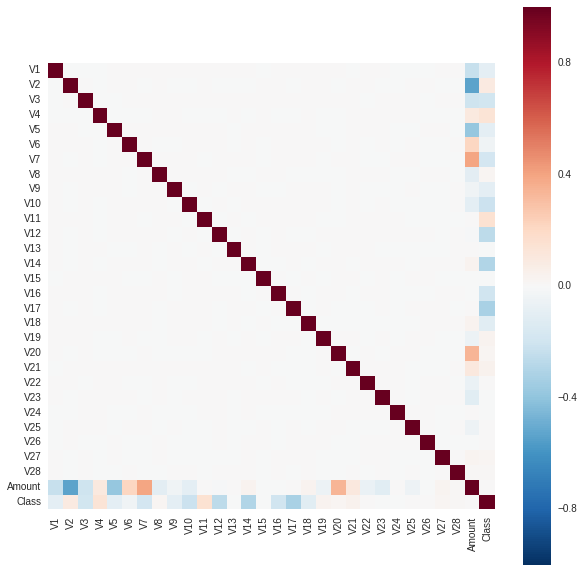

In [3]:
ds = dataset.iloc[:, 1:]
correlation = ds.corr()
plt.figure(figsize = (10, 10))
sns.heatmap(correlation, vmax = 1, square = True, annot = False)
plt.savefig('pearson.pdf')
plt.show()

I don't see any correlation between Amount and Class here. Maybe we should reject it?

In [4]:
from sklearn.cross_validation import train_test_split
dataset = dataset.iloc[:, 1:]
x_data = dataset.iloc[:, :-2].values.astype(np.float32)
y_data = dataset.iloc[:, -1]

onehot = np.zeros((y_data.shape[0], np.unique(y_data).shape[0]))
for i in xrange(y_data.shape[0]):
    onehot[i, y_data[i]] = 1.0
    
x_train, x_test, y_train, y_test, _, y_test_label = train_test_split(x_data, onehot, y_data, test_size = 0.2)

/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [5]:
size_layer_first = 512
size_layer_second = 128
learning_rate = 0.001
beta = 0.00005

X = tf.placeholder("float", [None, x_train.shape[1]])
Y = tf.placeholder("float", [None, np.unique(y_data).shape[0]])
layer1 = tf.Variable(tf.random_normal([x_train.shape[1], size_layer_first]))
layer2 = tf.Variable(tf.random_normal([size_layer_first, size_layer_first]))
layer3 = tf.Variable(tf.random_normal([size_layer_first, size_layer_second]))
layer4 = tf.Variable(tf.random_normal([size_layer_second, np.unique(y_data).shape[0]]))

bias1 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias2 = tf.Variable(tf.random_normal([size_layer_first], stddev = 0.1))
bias3 = tf.Variable(tf.random_normal([size_layer_second], stddev = 0.1))
bias4 = tf.Variable(tf.random_normal([np.unique(y_data).shape[0]], stddev = 0.1))

hidden1 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(X, layer1) + bias1), 0.3)
hidden2 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(hidden1, layer2) + bias2), 0.3)
hidden3 = tf.nn.dropout(tf.nn.sigmoid(tf.matmul(hidden2, layer3) + bias3), 0.3)
hidden4 = tf.matmul(hidden3, layer4) + bias4

loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels = Y, logits = hidden4))
loss += tf.nn.l2_loss(layer1) * beta + tf.nn.l2_loss(layer2) * beta + tf.nn.l2_loss(layer3) * beta + tf.nn.l2_loss(layer4) * beta

optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(loss)

correct_pred = tf.equal(tf.argmax(hidden4, 1), tf.argmax(Y, 1))
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

In [6]:
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())
import time

BATCH_SIZE = 128

EPOCH, LOSS, ACC = [], [], []
for i in xrange(10):
    last = time.time()
    EPOCH.append(i)
    TOTAL_LOSS, ACCURACY = 0, 0
    for n in xrange(0, (x_train.shape[0] // BATCH_SIZE) * BATCH_SIZE, BATCH_SIZE):
        cost, _ = sess.run([loss, optimizer], feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        ACCURACY += sess.run(accuracy, feed_dict = {X : x_train[n: n + BATCH_SIZE, :], Y : y_train[n: n + BATCH_SIZE, :]})
        TOTAL_LOSS += cost
    
    TOTAL_LOSS /= (x_train.shape[0] // BATCH_SIZE)
    ACCURACY /= (x_train.shape[0] // BATCH_SIZE)
    LOSS.append(TOTAL_LOSS); ACC.append(ACCURACY)
    print 'epoch: ' + str(i + 1) + ', loss: ' + str(TOTAL_LOSS) + ', accuracy: ' + str(ACCURACY) + ', s / epoch: ' + str(time.time() - last)

epoch: 1, loss: 8.10512757623, accuracy: 0.985832162921, s / epoch: 24.1923840046
epoch: 2, loss: 6.28414781978, accuracy: 0.99650193118, s / epoch: 22.1745769978
epoch: 3, loss: 4.40792049478, accuracy: 0.996616046348, s / epoch: 21.4778430462
epoch: 4, loss: 2.77917617292, accuracy: 0.997191011236, s / epoch: 21.9595429897
epoch: 5, loss: 1.48631228265, accuracy: 0.998134655899, s / epoch: 21.2457540035
epoch: 6, loss: 0.598144482227, accuracy: 0.998270716292, s / epoch: 19.8622908592
epoch: 7, loss: 0.169177042178, accuracy: 0.998275105337, s / epoch: 19.8599021435
epoch: 8, loss: 0.0420715748254, accuracy: 0.998279494382, s / epoch: 27.7041568756
epoch: 9, loss: 0.019759179527, accuracy: 0.998279494382, s / epoch: 30.1247770786
epoch: 10, loss: 0.0168416270487, accuracy: 0.998279494382, s / epoch: 27.4476659298


In [7]:
from sklearn import metrics
testing_acc, logits = sess.run([accuracy, tf.cast(tf.argmax(hidden4, 1), tf.int32)], feed_dict = {X : x_test, Y : y_test})
print 'testing accuracy: ' + str(testing_acc)
print(metrics.classification_report(y_test_label, logits, target_names = ['non', 'fraud']))

testing accuracy: 0.998244
             precision    recall  f1-score   support

        non       1.00      1.00      1.00     56865
      fraud       0.00      0.00      0.00        97

avg / total       1.00      1.00      1.00     56962



/usr/local/lib/python2.7/dist-packages/sklearn/metrics/classification.py:1113: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


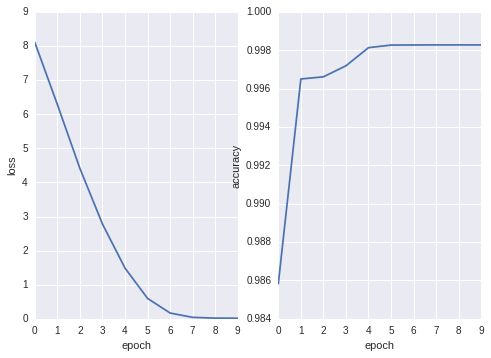

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
plt.subplot(1, 2, 1)
plt.plot(EPOCH, LOSS)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACC)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()